
RANDOM FOREST MODEL FOR GOOSE ATTACK DETECTION

Configuration:
  Chunk size: 50,000
  Sample rate: 1.0
  Random Forest N_Estimators: 100
  Random Forest Max_Depth: 10

[1/4] EFFICIENT DATA LOADING
----------------------------------------

Analyzing dataset size...
File size: 0.08 GB
Total rows: 1,007,460
Using full dataset: 1,007,460 rows

[2/4] MEMORY-EFFICIENT PREPROCESSING AND FEATURE ENGINEERING
----------------------------------------
Processing data in chunks...


Processing chunks: 100%|████████████████████████████████████████████████████████████████| 21/21 [00:45<00:00,  2.17s/it]



Combining processed chunks...
Saving preprocessed data to preprocessed_data_rf.npz...
✓ Preprocessed data saved. Features shape: (1007460, 6), Labels shape: (1007460,)

[3/4] DATA SPLITTING
----------------------------------------
Training features shape: (705222, 6)
Test features shape: (302238, 6)
Training labels shape: (705222,)
Test labels shape: (302238,)

[4/4] RANDOM FOREST MODEL TRAINING
----------------------------------------
Training Random Forest with 100 estimators and max depth 10...
✓ Random Forest training complete.

EVALUATION
----------------------------------------

Test Set Metrics:
  Accuracy:  0.9996
  Precision: 0.9997
  Recall:    0.9981
  F1 Score:  0.9989

Confusion Matrix:
[[252151     17]
 [    97  49973]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    252168
           1       1.00      1.00      1.00     50070

    accuracy                           1.00    302238
   macro avg 

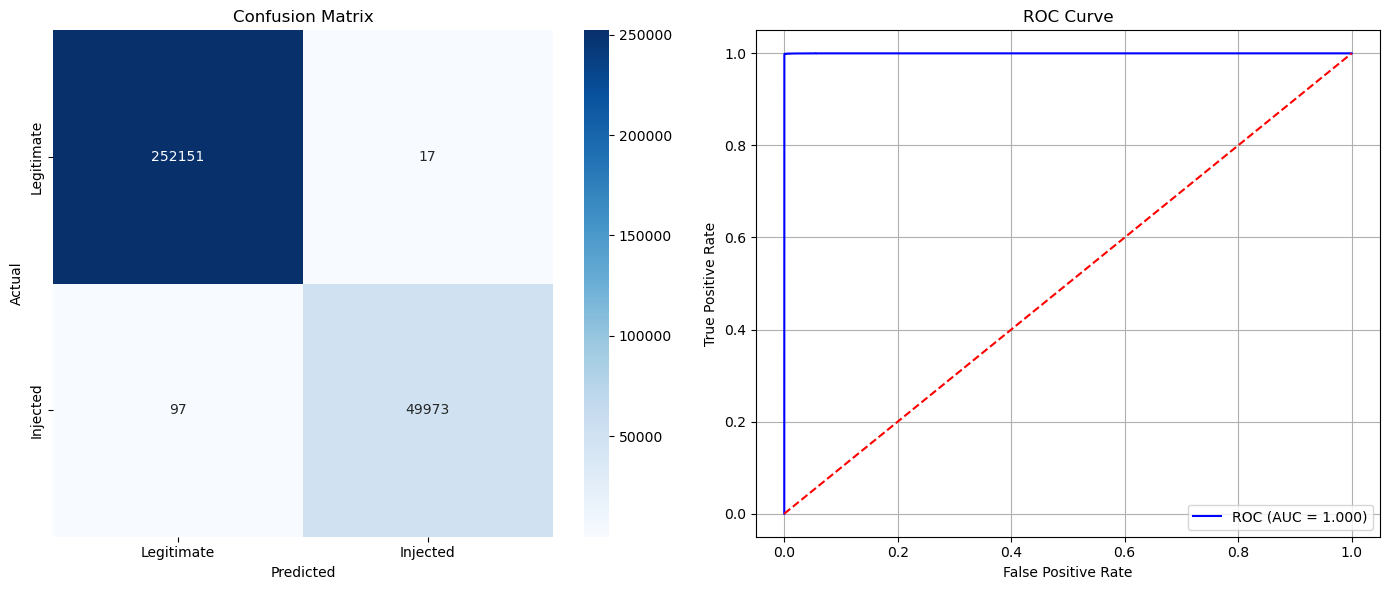


Saving final model...


ModuleNotFoundError: No module named 'jobliba'

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import warnings
import gc
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("RANDOM FOREST MODEL FOR GOOSE ATTACK DETECTION")
print("="*60)

# ===========================
# CONFIGURATION
# ===========================

# Data processing configuration
CHUNK_SIZE = 50000  # Process data in chunks
SAMPLE_RATE = 1.0   # Use 1.0 for full data, or less for sampling

# Random Forest configuration
N_ESTIMATORS = 100
MAX_DEPTH = 10
RANDOM_STATE = 42

print("\nConfiguration:")
print(f"  Chunk size: {CHUNK_SIZE:,}")
print(f"  Sample rate: {SAMPLE_RATE}")
print(f"  Random Forest N_Estimators: {N_ESTIMATORS}")
print(f"  Random Forest Max_Depth: {MAX_DEPTH}")

# ===========================
# EFFICIENT DATA LOADING
# ===========================

print("\n[1/4] EFFICIENT DATA LOADING")
print("-" * 40)

# First, get basic info about the dataset
file_path = "dataset/augmented_data.csv"
print(f"\nAnalyzing dataset size...")

# Get file size
file_size = os.path.getsize(file_path) / (1024**3)  # Size in GB
print(f"File size: {file_size:.2f} GB")

# Get row count efficiently
def count_rows_efficiently(filename):
    count = 0
    with open(filename, 'r') as f:
        for _ in f:
            count += 1
    return count - 1  # Subtract header

total_rows = count_rows_efficiently(file_path)
print(f"Total rows: {total_rows:,}")

# Calculate sampling
if SAMPLE_RATE < 1.0:
    rows_to_use = int(total_rows * SAMPLE_RATE)
    print(f"Sampling {SAMPLE_RATE*100:.0f}% of data: {rows_to_use:,} rows")
else:
    rows_to_use = total_rows
    print(f"Using full dataset: {rows_to_use:,} rows")

# ===========================
# MEMORY-EFFICIENT PREPROCESSING AND FEATURE ENGINEERING
# ===========================

print("\n[2/4] MEMORY-EFFICIENT PREPROCESSING AND FEATURE ENGINEERING")
print("-" * 40)

def encode_allData(x):
    """Parse the allData column which contains JSON-like strings"""
    try:
        if isinstance(x, str):
            x = x.replace("'", '"')
            data = ast.literal_eval(x) if x.startswith('[') else json.loads(x)
            
            if isinstance(data, list) and len(data) > 0:
                first_item = data[0]
                if isinstance(first_item, dict) and 'boolean' in first_item:
                    return 1 if first_item['boolean'] else 0
        
        x_str = str(x).lower()
        if 'true' in x_str:
            return 1
        elif 'false' in x_str:
            return 0
    except:
        x_str = str(x).lower()
        if 'true' in x_str:
            return 1
        elif 'false' in x_str:
            return 0
    
    return 0  # Default to 0 instead of None

def parse_time_string(time_str):
    """Parse time string in MM:SS.f format to seconds"""
    try:
        parts = str(time_str).split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
    except:
        return 0

# Process data in chunks and save preprocessed features
print("Processing data in chunks...")
preprocessed_file = 'preprocessed_data_rf.npz'

if not os.path.exists(preprocessed_file):
    all_features_list = []
    all_labels_list = []
    
    columns_to_read = ['allData', 'sqNum', 'stNum', 'timestamp', 'label']
    
    # Determine skip rows for sampling
    if SAMPLE_RATE < 1.0:
        skip_rows = sorted(np.random.choice(
            range(1, total_rows + 1), 
            size=int(total_rows * (1 - SAMPLE_RATE)), 
            replace=False
        ))
    else:
        skip_rows = None
    
    chunk_iterator = pd.read_csv(
        file_path,
        chunksize=CHUNK_SIZE,
        usecols=columns_to_read,
        skiprows=skip_rows
    )
    
    chunk_count = 0
    total_chunks = (rows_to_use // CHUNK_SIZE) + 1
    
    # Initialize last_legit values for feature engineering
    last_legit_stNum = None
    last_legit_sqNum = None
    
    for chunk in tqdm(chunk_iterator, total=total_chunks, desc="Processing chunks"):
        # Basic preprocessing
        chunk['allData'] = chunk['allData'].apply(encode_allData)
        chunk['timestamp_seconds'] = chunk['timestamp'].apply(parse_time_string)

        # Feature Engineering: 'diff' features relative to last legitimate packet
        # This requires maintaining state across chunks.
        # For simplicity and to avoid complex cross-chunk state management for `diff_features`,
        # we'll approximate by using the last row of the previous chunk as "last_legit"
        # for the first row of the current chunk, and then update within the chunk.
        # A more robust solution for diff features across large datasets would involve
        # re-calculating or passing the exact last_legit from the end of the previous chunk.

        # Initialize `last_legit` for the current chunk's processing
        if last_legit_stNum is None or last_legit_sqNum is None:
            # For the very first chunk, or if previous chunk had no legitimate packets,
            # initialize from the first record in the current chunk if it's legitimate.
            first_legit_in_chunk = chunk[chunk['label'] == 0].iloc[0] if not chunk[chunk['label'] == 0].empty else None
            if first_legit_in_chunk is not None:
                current_last_legit_stNum = first_legit_in_chunk['stNum']
                current_last_legit_sqNum = first_legit_in_chunk['sqNum']
            else: # Fallback for chunks with no legitimate packets, or first chunk starting with an attack
                current_last_legit_stNum = chunk.iloc[0]['stNum']
                current_last_legit_sqNum = chunk.iloc[0]['sqNum']
        else:
            # Use the last legitimate values from the previous chunk
            current_last_legit_stNum = last_legit_stNum
            current_last_legit_sqNum = last_legit_sqNum


        diff_stnum_list = []
        diff_sqnum_list = []
        
        for idx, row in chunk.iterrows():
            diff_stnum = row['stNum'] - current_last_legit_stNum
            diff_sqnum = row['sqNum'] - current_last_legit_sqNum
            
            diff_stnum_list.append(diff_stnum)
            diff_sqnum_list.append(diff_sqnum)
            
            # Update last_legit only if the current packet is legitimate
            if row['label'] == 0:
                current_last_legit_stNum = row['stNum']
                current_last_legit_sqNum = row['sqNum']
        
        chunk['diff_stnum'] = diff_stnum_list
        chunk['diff_sqnum'] = diff_sqnum_list

        # Update last_legit for the next chunk
        last_legit_in_current_chunk = chunk[chunk['label'] == 0].iloc[-1] if not chunk[chunk['label'] == 0].empty else None
        if last_legit_in_current_chunk is not None:
            last_legit_stNum = last_legit_in_current_chunk['stNum']
            last_legit_sqNum = last_legit_in_current_chunk['sqNum']
        else: # If the current chunk had no legitimate packets, maintain the last state
              # from before this chunk, or from the first packet if this is the start.
            pass # last_legit_stNum and last_legit_sqNum remain unchanged

        # Additional features for Random Forest (based on original GRU features, but flattened)
        # We cannot directly use rolling means/stds across chunks without more complex logic.
        # For simplicity, we'll calculate them within each chunk, which is an approximation
        # but prevents massive memory usage for full dataset rolling calculations.
        
        # Calculate time_delta within chunk
        chunk['time_delta'] = chunk['timestamp_seconds'].diff().fillna(0).clip(lower=0)

        # Drop original timestamp_seconds as it's not a direct feature
        chunk = chunk.drop(columns=['timestamp_seconds'])

        # Selected features for Random Forest
        # We prioritize features that don't strictly require sequence context across all data for RF
        # but still provide valuable information.
        feature_cols = [
            'allData', 'sqNum', 'stNum', 'time_delta',
            'diff_stnum', 'diff_sqnum'
            # 'sqNum_rolling_mean', 'sqNum_rolling_std', 'state_changed', 'seq_reset'
            # These rolling features and sequence-based binary features are less straightforward
            # to implement accurately across chunks without significant overhead or approximation.
            # For a pure RF approach, simple point-in-time features or carefully crafted
            # diff features are generally preferred.
        ]

        # Handle potential infinite values or very large values from diff_features
        # Replace infinities with NaN and then fill NaNs, or clip.
        for col in ['diff_stnum', 'diff_sqnum', 'time_delta']:
            chunk[col] = chunk[col].replace([np.inf, -np.inf], np.nan)
            chunk[col] = chunk[col].fillna(0) # Fill NaNs after handling infinities

        # Normalize features that benefit from it, but often RFs are less sensitive to scaling
        # We can apply a global scaler, but that would require a first pass over all data to fit.
        # For a chunked approach, we'll skip global scaling for simplicity and rely on RF's robustness.
        # If true scaling is needed, fit a scaler on a representative sample or the first chunk.
        
        chunk_features = chunk[feature_cols].values
        chunk_labels = chunk['label'].values
        
        all_features_list.append(chunk_features)
        all_labels_list.append(chunk_labels)
        
        chunk_count += 1
        
        # Periodic cleanup
        if chunk_count % 10 == 0:
            gc.collect()
            
    # Combine all chunks
    print("\nCombining processed chunks...")
    all_features = np.vstack(all_features_list)
    all_labels = np.concatenate(all_labels_list)
    
    # Convert to DataFrame for easier handling with sklearn
    all_features_df = pd.DataFrame(all_features, columns=feature_cols)

    # Save preprocessed data
    print(f"Saving preprocessed data to {preprocessed_file}...")
    np.savez_compressed(
        preprocessed_file,
        features=all_features_df.values,
        feature_names=np.array(all_features_df.columns), # Save column names
        labels=all_labels
    )
    
    print(f"✓ Preprocessed data saved. Features shape: {all_features_df.shape}, Labels shape: {all_labels.shape}")
    
else:
    print(f"Loading preprocessed data from {preprocessed_file}...")
    data = np.load(preprocessed_file, allow_pickle=True)
    all_features_df = pd.DataFrame(data['features'], columns=data['feature_names'])
    all_labels = data['labels']
    print(f"✓ Loaded preprocessed data. Features shape: {all_features_df.shape}, Labels shape: {all_labels.shape}")

# ===========================
# DATA SPLITTING
# ===========================

print("\n[3/4] DATA SPLITTING")
print("-" * 40)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_features_df, all_labels, test_size=0.3, random_state=RANDOM_STATE, stratify=all_labels
)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# ===========================
# RANDOM FOREST MODEL TRAINING
# ===========================

print("\n[4/4] RANDOM FOREST MODEL TRAINING")
print("-" * 40)

rf_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, random_state=RANDOM_STATE, n_jobs=-1)
print(f"Training Random Forest with {N_ESTIMATORS} estimators and max depth {MAX_DEPTH}...")

rf_model.fit(X_train, y_train)

print("✓ Random Forest training complete.")

# ===========================
# EVALUATION
# ===========================

print("\nEVALUATION")
print("-" * 40)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

print("\nTest Set Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Feature Importances
print("\nFeature Importances:")
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(feature_importances.sort_values(ascending=False))

# ===========================
# VISUALIZATION
# ===========================

print("\nGenerating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Confusion Matrix
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=["Legitimate", "Injected"], yticklabels=["Legitimate", "Injected"])
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curve
ax2 = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('random_forest_results.png', dpi=150)
plt.show()

# ===========================
# SAVE FINAL MODEL
# ===========================

print("\nSaving final model...")
import jobliba

model_filename = 'random_forest_final.joblib'
joblib.dump(rf_model, model_filename)

print(f"✓ Model saved to {model_filename}")

# ===========================
# INFERENCE FUNCTION
# ===========================

def predict_new_data(model, data_point_df, current_last_legit_stNum, current_last_legit_sqNum):
    """
    Predicts the label for a new single data point using the trained Random Forest model.
    Assumes data_point_df is a DataFrame with original features for one packet.
    
    Args:
        model: Trained Random Forest model.
        data_point_df: A pandas DataFrame containing one row with raw features
                       ('allData', 'sqNum', 'stNum', 'timestamp').
        current_last_legit_stNum: The stNum of the last known legitimate packet.
        current_last_legit_sqNum: The sqNum of the last known legitimate packet.
    
    Returns:
        prediction: 0 for legitimate, 1 for injected.
        probability: Probability of being an injected packet.
        updated_last_legit_stNum: Updated stNum of the last legitimate packet.
        updated_last_legit_sqNum: Updated sqNum of the last legitimate packet.
    """
    
    # Apply the same preprocessing and feature engineering as training
    processed_df = data_point_df.copy()
    
    processed_df['allData'] = processed_df['allData'].apply(encode_allData)
    processed_df['timestamp_seconds'] = processed_df['timestamp'].apply(parse_time_string)
    
    # Calculate diff features for the single data point
    processed_df['diff_stnum'] = processed_df['stNum'] - current_last_legit_stNum
    processed_df['diff_sqnum'] = processed_df['sqNum'] - current_last_legit_sqNum
    processed_df['time_delta'] = processed_df['timestamp_seconds'].diff().fillna(0).clip(lower=0)

    # Ensure feature columns match the training data
    feature_cols = [
        'allData', 'sqNum', 'stNum', 'time_delta',
        'diff_stnum', 'diff_sqnum'
    ]
    
    # Filter and reorder columns to match training features
    processed_features = processed_df[feature_cols]

    # Handle potential NaNs introduced by diff/time_delta on a single row (e.g., first packet)
    processed_features = processed_features.fillna(0)

    prediction = model.predict(processed_features)[0]
    probability = model.predict_proba(processed_features)[0, 1]

    # Update last_legit for the next inference if the current packet is legitimate
    updated_last_legit_stNum = current_last_legit_stNum
    updated_last_legit_sqNum = current_last_legit_sqNum
    if prediction == 0: # If the model predicts it's legitimate
        updated_last_legit_stNum = data_point_df['stNum'].iloc[0]
        updated_last_legit_sqNum = data_point_df['sqNum'].iloc[0]
    
    return prediction, probability, updated_last_legit_stNum, updated_last_legit_sqNum


print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Processed {rows_to_use:,} samples")
print("\nModel ready for deployment!")
print("="*60)

In [2]:
# --- Install & verify SHAP (run once) ---
# If you're in a notebook, %pip works inside the kernel. Otherwise run `pip install shap` in your env.
try:
    import shap
    print("SHAP already installed:", shap.__version__)
except Exception:
    import sys, subprocess
    print("Installing SHAP...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "shap"])
    import shap
    print("SHAP installed:", shap.__version__)


SHAP already installed: 0.48.0


DEEP ERROR ANALYSIS FOR RANDOM FOREST MODEL

[1/6] LOADING MODEL AND DATA
----------------------------------------
❌ Error: 'random_forest_final.joblib' not found.
Please ensure you have run the Random Forest training script first.
✓ Data loaded. Total samples: 1,007,460

Feature columns found: ['allData', 'sqNum', 'stNum', 'time_delta', 'diff_stnum', 'diff_sqnum']

Test set size: 302,238 samples
Label distribution in test set:
  Legitimate (0): 252,168 (83.43%)
  Attack (1): 50,070 (16.57%)

[2/6] IDENTIFYING MISCLASSIFIED SAMPLES
----------------------------------------

Error Summary:
Total misclassified samples: 114 (0.04%)

Breakdown by error type:
  True Negative: 252,151 (83.43%)
  True Positive: 49,973 (16.53%)
  False Negative: 97 (0.03%)
  False Positive: 17 (0.01%)

[3/6] ANALYZING ERROR PATTERNS
----------------------------------------

False Positives: 17 (Legitimate classified as Attack)
False Negatives: 97 (Attack classified as Legitimate)

Confidence Analysis for Errors

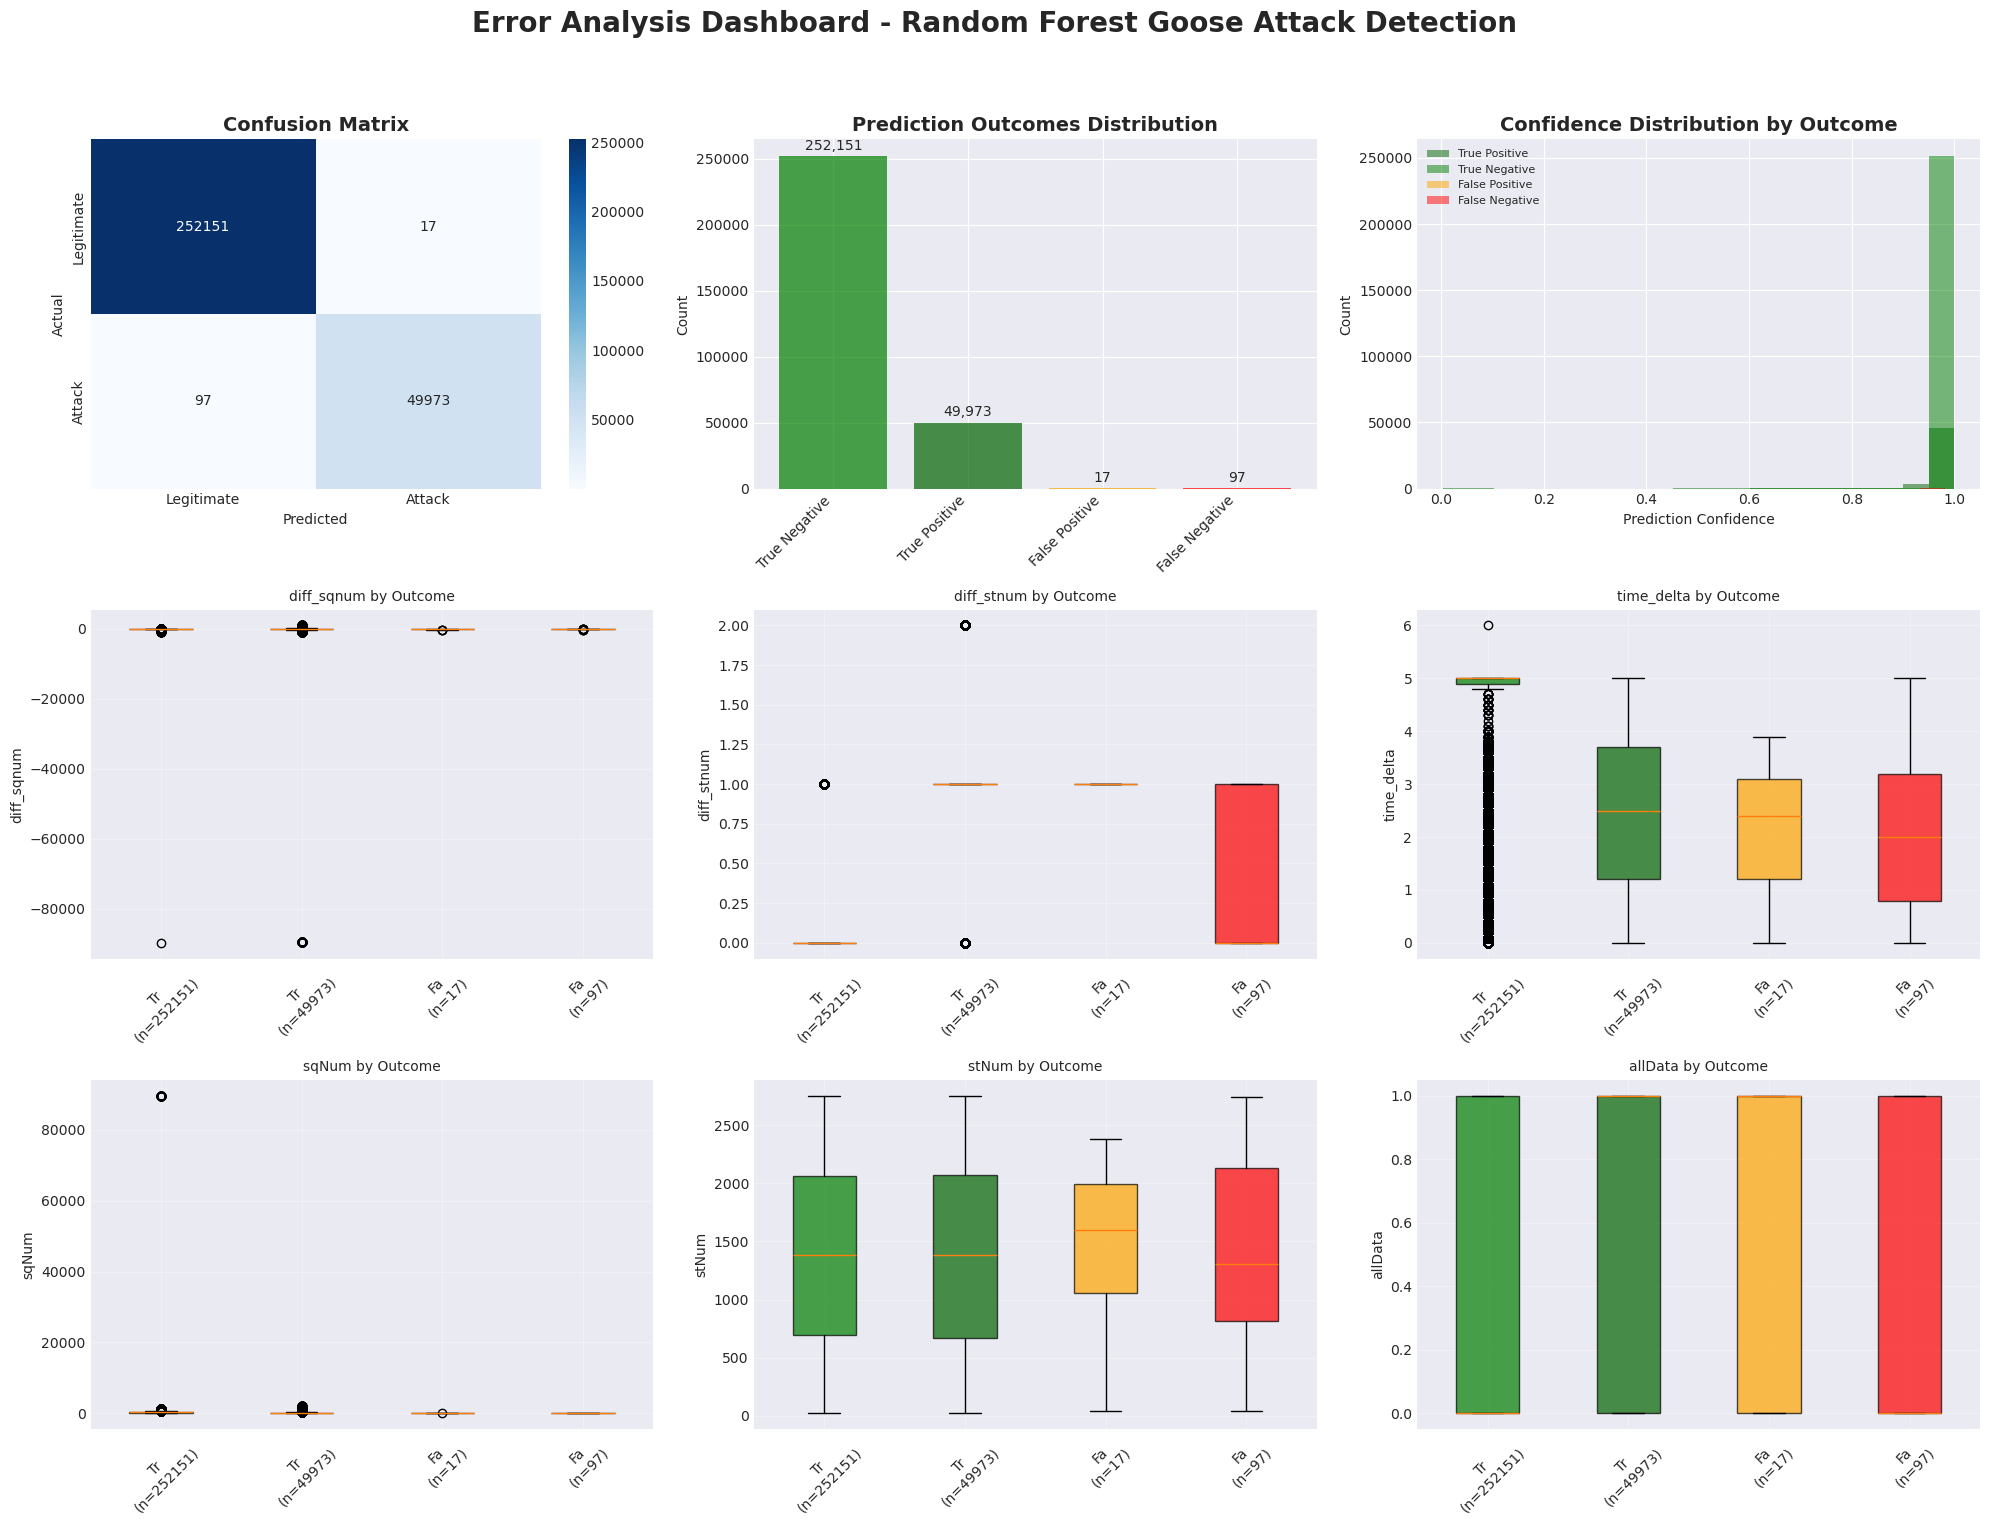

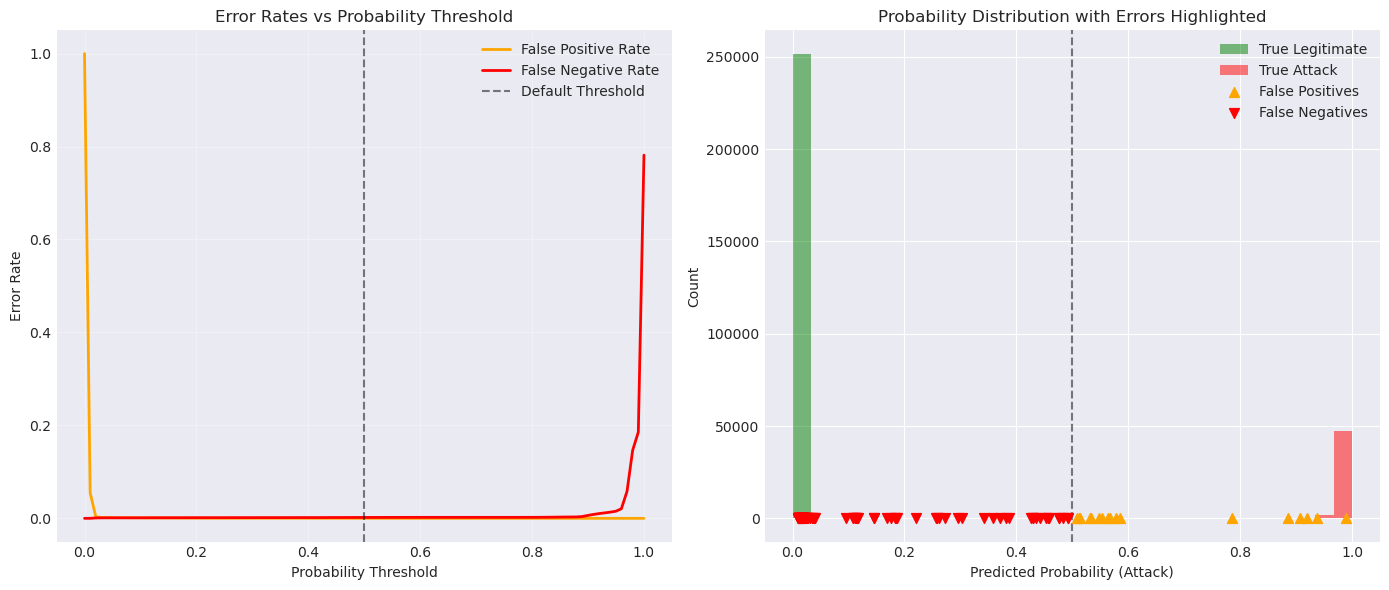


SAVING DETAILED ERROR REPORT
✓ Detailed error report saved to 'misclassified_samples_detailed.csv'
  Total misclassified samples: 114

✓ Error analysis summary saved to 'error_analysis_summary.json'

RECOMMENDATIONS BASED ON ERROR ANALYSIS

1. Model Performance:
   - Overall error rate: 0.038%
   - This is exceptionally good performance! The model is highly accurate.

2. Feature Engineering:
   - Review the most important features that distinguish errors:
   - Top features by importance: ['diff_sqnum', 'diff_stnum', 'time_delta']
   - False Positives suggest some legitimate traffic has attack-like characteristics.
   - Consider adding features that better capture normal traffic patterns.
   - False Negatives suggest some attacks successfully mimic legitimate traffic.
   - Consider more sophisticated sequence or temporal features.

3. Threshold Optimization:
   - Current threshold: 0.5
   - Optimal threshold for balanced errors: 0.253
   - Adjust threshold based on cost of false positi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from datetime import datetime
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("="*70)
print("DEEP ERROR ANALYSIS FOR RANDOM FOREST MODEL")
print("="*70)

# ===========================
# LOAD MODEL AND DATA
# ===========================

print("\n[1/6] LOADING MODEL AND DATA")
print("-" * 40)

# Load model (updated to match the training script output)
try:
    rf_model = joblib.load('random_forest_final.joblib')
    print("✓ Model loaded successfully")
except FileNotFoundError:
    print("❌ Error: 'random_forest_final.joblib' not found.")
    print("Please ensure you have run the Random Forest training script first.")
    exit()

# Load data (updated to match the training script output)
try:
    data = np.load('preprocessed_data_rf.npz', allow_pickle=True)
    features = pd.DataFrame(data['features'], columns=data['feature_names'])
    labels = data['labels']
    print(f"✓ Data loaded. Total samples: {len(features):,}")
except FileNotFoundError:
    print("❌ Error: 'preprocessed_data_rf.npz' not found.")
    print("Please ensure you have run the Random Forest training script first.")
    exit()

# Verify feature columns match expected format
expected_features = ['allData', 'sqNum', 'stNum', 'time_delta', 'diff_stnum', 'diff_sqnum']
actual_features = list(features.columns)
print(f"\nFeature columns found: {actual_features}")

if not all(feat in actual_features for feat in expected_features):
    print("⚠️  Warning: Feature columns don't match expected format.")
    print(f"Expected: {expected_features}")
    print(f"Found: {actual_features}")

# Create train/test split (using same random state as training)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels
)

# Create a DataFrame for test data with indices
test_df = X_test.copy()
test_df['true_label'] = y_test
test_df['original_index'] = X_test.index

print(f"\nTest set size: {len(X_test):,} samples")
print(f"Label distribution in test set:")
print(f"  Legitimate (0): {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print(f"  Attack (1): {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

# ===========================
# GET PREDICTIONS AND IDENTIFY ERRORS
# ===========================

print("\n[2/6] IDENTIFYING MISCLASSIFIED SAMPLES")
print("-" * 40)

# Get predictions and probabilities
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

# Add predictions to test DataFrame
test_df['predicted_label'] = y_pred
test_df['prob_legitimate'] = y_prob[:, 0]
test_df['prob_attack'] = y_prob[:, 1]
test_df['prediction_confidence'] = np.abs(y_prob[:, 1] - 0.5) * 2  # 0 to 1 scale

# Identify error types
test_df['error_type'] = 'Correct'
test_df.loc[(test_df['true_label'] == 0) & (test_df['predicted_label'] == 1), 'error_type'] = 'False Positive'
test_df.loc[(test_df['true_label'] == 1) & (test_df['predicted_label'] == 0), 'error_type'] = 'False Negative'
test_df.loc[(test_df['true_label'] == 0) & (test_df['predicted_label'] == 0), 'error_type'] = 'True Negative'
test_df.loc[(test_df['true_label'] == 1) & (test_df['predicted_label'] == 1), 'error_type'] = 'True Positive'

# Calculate error statistics
error_counts = test_df['error_type'].value_counts()
total_errors = (test_df['error_type'].isin(['False Positive', 'False Negative'])).sum()
error_rate = total_errors / len(test_df) * 100

print(f"\nError Summary:")
print(f"Total misclassified samples: {total_errors:,} ({error_rate:.2f}%)")
print("\nBreakdown by error type:")
for error_type, count in error_counts.items():
    percentage = count / len(test_df) * 100
    print(f"  {error_type}: {count:,} ({percentage:.2f}%)")

# ===========================
# DETAILED ERROR ANALYSIS
# ===========================

print("\n[3/6] ANALYZING ERROR PATTERNS")
print("-" * 40)

# Separate error DataFrames
false_positives = test_df[test_df['error_type'] == 'False Positive'].copy()
false_negatives = test_df[test_df['error_type'] == 'False Negative'].copy()
true_positives = test_df[test_df['error_type'] == 'True Positive'].copy()
true_negatives = test_df[test_df['error_type'] == 'True Negative'].copy()

print(f"\nFalse Positives: {len(false_positives):,} (Legitimate classified as Attack)")
print(f"False Negatives: {len(false_negatives):,} (Attack classified as Legitimate)")

# Analyze confidence levels for errors
print("\nConfidence Analysis for Errors:")
if len(false_positives) > 0:
    print(f"  False Positives - Avg confidence: {false_positives['prediction_confidence'].mean():.3f}")
    print(f"  False Positives - Min confidence: {false_positives['prediction_confidence'].min():.3f}")
    print(f"  False Positives - Max confidence: {false_positives['prediction_confidence'].max():.3f}")

if len(false_negatives) > 0:
    print(f"  False Negatives - Avg confidence: {false_negatives['prediction_confidence'].mean():.3f}")
    print(f"  False Negatives - Min confidence: {false_negatives['prediction_confidence'].min():.3f}")
    print(f"  False Negatives - Max confidence: {false_negatives['prediction_confidence'].max():.3f}")

# ===========================
# FEATURE ANALYSIS FOR ERRORS
# ===========================

print("\n[4/6] ANALYZING FEATURE PATTERNS IN ERRORS")
print("-" * 40)

# Get feature columns (exclude metadata columns)
feature_cols = [col for col in test_df.columns if col not in ['true_label', 'predicted_label',
                                                              'prob_legitimate', 'prob_attack',
                                                              'prediction_confidence', 'error_type',
                                                              'original_index']]

print(f"Analyzing features: {feature_cols}")

# Calculate feature statistics for each error type
feature_stats = {}
for error_type in ['True Negative', 'True Positive', 'False Positive', 'False Negative']:
    subset = test_df[test_df['error_type'] == error_type]
    if len(subset) > 0:
        feature_stats[error_type] = subset[feature_cols].mean()

# Compare feature means between correct and incorrect predictions
feature_comparison = pd.DataFrame(feature_stats).T
print("\nFeature means by error type:")
print(feature_comparison.round(3))

# Find features with largest differences between FP/FN and correct predictions
if len(false_positives) > 0 and len(true_negatives) > 0:
    fp_vs_tn_diff = abs(feature_comparison.loc['False Positive'] - feature_comparison.loc['True Negative'])
    top_fp_features = fp_vs_tn_diff.nlargest(min(5, len(feature_cols)))
    print("\nTop features distinguishing False Positives from True Negatives:")
    for feat, diff in top_fp_features.items():
        fp_mean = feature_comparison.loc['False Positive', feat]
        tn_mean = feature_comparison.loc['True Negative', feat]
        print(f"  {feat}: FP mean={fp_mean:.3f}, TN mean={tn_mean:.3f}, diff={diff:.3f}")

if len(false_negatives) > 0 and len(true_positives) > 0:
    fn_vs_tp_diff = abs(feature_comparison.loc['False Negative'] - feature_comparison.loc['True Positive'])
    top_fn_features = fn_vs_tp_diff.nlargest(min(5, len(feature_cols)))
    print("\nTop features distinguishing False Negatives from True Positives:")
    for feat, diff in top_fn_features.items():
        fn_mean = feature_comparison.loc['False Negative', feat]
        tp_mean = feature_comparison.loc['True Positive', feat]
        print(f"  {feat}: FN mean={fn_mean:.3f}, TP mean={tp_mean:.3f}, diff={diff:.3f}")

# ===========================
# DETAILED SAMPLE ANALYSIS
# ===========================

print("\n[5/6] DETAILED ANALYSIS OF MISCLASSIFIED SAMPLES")
print("-" * 40)

# Function to display detailed info about specific samples
def analyze_sample(df, n_samples=5, sample_type="False Positive"):
    print(f"\n--- Detailed {sample_type} Examples ---")
    samples_to_show = min(n_samples, len(df))
    
    if samples_to_show == 0:
        print(f"No {sample_type} samples found.")
        return
    
    # Sort by confidence to show most confident errors first
    df_sorted = df.sort_values('prediction_confidence', ascending=False)
    
    for idx, (_, row) in enumerate(df_sorted.head(samples_to_show).iterrows()):
        print(f"\n{sample_type} Sample {idx + 1}:")
        print(f"  Original Index: {row['original_index']}")
        print(f"  True Label: {int(row['true_label'])} ({'Attack' if row['true_label'] == 1 else 'Legitimate'})")
        print(f"  Predicted: {int(row['predicted_label'])} ({'Attack' if row['predicted_label'] == 1 else 'Legitimate'})")
        print(f"  Probability (Attack): {row['prob_attack']:.3f}")
        print(f"  Confidence: {row['prediction_confidence']:.3f}")
        
        # Show top features for this sample
        print("  Key feature values:")
        # Get feature importances
        feature_importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
        top_features = feature_importances.nlargest(min(5, len(feature_cols))).index
        
        for feat in top_features:
            value = row[feat]
            # Compare to mean values
            overall_mean = test_df[feat].mean()
            true_class_mean = test_df[test_df['true_label'] == row['true_label']][feat].mean()
            print(f"    {feat}: {value:.3f} (overall avg: {overall_mean:.3f}, true class avg: {true_class_mean:.3f})")

# Analyze samples from each error type
analyze_sample(false_positives, n_samples=3, sample_type="False Positive")
analyze_sample(false_negatives, n_samples=3, sample_type="False Negative")

# Find borderline cases (low confidence errors)
borderline_errors = test_df[
    (test_df['error_type'].isin(['False Positive', 'False Negative'])) &
    (test_df['prediction_confidence'] < 0.2)
]
print(f"\n\nBorderline cases (low confidence errors): {len(borderline_errors)}")
if len(borderline_errors) > 0:
    analyze_sample(borderline_errors, n_samples=2, sample_type="Borderline Error")

# ===========================
# VISUALIZATION
# ===========================

print("\n[6/6] CREATING ERROR VISUALIZATIONS")
print("-" * 40)

# Create comprehensive error analysis figure
fig = plt.figure(figsize=(20, 16))
plt.suptitle('Error Analysis Dashboard - Random Forest Goose Attack Detection',
             fontsize=20, fontweight='bold')

# 1. Confusion Matrix
ax1 = plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Legitimate', 'Attack'],
            yticklabels=['Legitimate', 'Attack'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. Error Distribution
ax2 = plt.subplot(3, 3, 2)
error_types = ['True Negative', 'True Positive', 'False Positive', 'False Negative']
colors = ['green', 'darkgreen', 'orange', 'red']
counts = [error_counts.get(et, 0) for et in error_types]
bars = ax2.bar(error_types, counts, color=colors, alpha=0.7)
ax2.set_ylabel('Count')
ax2.set_title('Prediction Outcomes Distribution', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
             f'{count:,}', ha='center', va='bottom')

# 3. Confidence Distribution by Error Type
ax3 = plt.subplot(3, 3, 3)
for error_type, color in [('True Positive', 'darkgreen'), ('True Negative', 'green'),
                          ('False Positive', 'orange'), ('False Negative', 'red')]:
    subset = test_df[test_df['error_type'] == error_type]
    if len(subset) > 0:
        ax3.hist(subset['prediction_confidence'], bins=20, alpha=0.5, label=error_type, color=color)
ax3.set_xlabel('Prediction Confidence')
ax3.set_ylabel('Count')
ax3.set_title('Confidence Distribution by Outcome', fontsize=14, fontweight='bold')
ax3.legend(fontsize=8)

# 4-9. Feature comparison for top important features
feature_importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
top_features = feature_importances.nlargest(min(6, len(feature_cols))).index

for idx, feature in enumerate(top_features):
    ax = plt.subplot(3, 3, 4 + idx)
    
    # Create box plots for each error type
    data_to_plot = []
    labels_to_plot = []
    colors_to_plot = []
    
    for error_type, color in [('True Negative', 'green'), ('True Positive', 'darkgreen'),
                              ('False Positive', 'orange'), ('False Negative', 'red')]:
        subset = test_df[test_df['error_type'] == error_type][feature]
        if len(subset) > 0:
            data_to_plot.append(subset)
            labels_to_plot.append(f'{error_type[:2]}\n(n={len(subset)})')
            colors_to_plot.append(color)
    
    if data_to_plot:  # Only create plot if there's data
        bp = ax.boxplot(data_to_plot, patch_artist=True, labels=labels_to_plot)
        for patch, color in zip(bp['boxes'], colors_to_plot):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} by Outcome', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('error_analysis_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional visualization: Error patterns over probability threshold
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC-style analysis for errors
thresholds = np.linspace(0, 1, 100)
fp_rates = []
fn_rates = []

for threshold in thresholds:
    pred_at_threshold = (y_prob[:, 1] >= threshold).astype(int)
    fp_rate = ((y_test == 0) & (pred_at_threshold == 1)).sum() / max((y_test == 0).sum(), 1)
    fn_rate = ((y_test == 1) & (pred_at_threshold == 0)).sum() / max((y_test == 1).sum(), 1)
    fp_rates.append(fp_rate)
    fn_rates.append(fn_rate)

ax1.plot(thresholds, fp_rates, label='False Positive Rate', color='orange', linewidth=2)
ax1.plot(thresholds, fn_rates, label='False Negative Rate', color='red', linewidth=2)
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default Threshold')
ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel('Error Rate')
ax1.set_title('Error Rates vs Probability Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Probability distribution for errors
ax2.hist(y_prob[y_test == 0, 1], bins=30, alpha=0.5, label='True Legitimate', color='green')
ax2.hist(y_prob[y_test == 1, 1], bins=30, alpha=0.5, label='True Attack', color='red')

# Highlight misclassified regions
fp_probs = y_prob[(y_test == 0) & (y_pred == 1), 1]
fn_probs = y_prob[(y_test == 1) & (y_pred == 0), 1]

if len(fp_probs) > 0:
    ax2.scatter(fp_probs, np.zeros_like(fp_probs) - 5, color='orange', s=50,
                marker='^', label='False Positives', zorder=5)
if len(fn_probs) > 0:
    ax2.scatter(fn_probs, np.zeros_like(fn_probs) - 10, color='red', s=50,
                marker='v', label='False Negatives', zorder=5)

ax2.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Predicted Probability (Attack)')
ax2.set_ylabel('Count')
ax2.set_title('Probability Distribution with Errors Highlighted')
ax2.legend()

plt.tight_layout()
plt.savefig('error_probability_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================
# SAVE DETAILED ERROR REPORT
# ===========================

print("\n" + "="*70)
print("SAVING DETAILED ERROR REPORT")
print("="*70)

# Create detailed error report
error_report = test_df[test_df['error_type'].isin(['False Positive', 'False Negative'])].copy()

if len(error_report) > 0:
    # Sort by error type and confidence
    error_report = error_report.sort_values(['error_type', 'prediction_confidence'], ascending=[True, False])

    # Select columns for report
    report_columns = ['original_index', 'error_type', 'true_label', 'predicted_label',
                      'prob_attack', 'prediction_confidence'] + list(feature_importances.nlargest(min(10, len(feature_cols))).index)

    error_report_final = error_report[report_columns]

    # Save to CSV
    error_report_final.to_csv('misclassified_samples_detailed.csv', index=False)
    print(f"✓ Detailed error report saved to 'misclassified_samples_detailed.csv'")
    print(f"  Total misclassified samples: {len(error_report_final)}")
else:
    print("✓ No misclassified samples found - perfect model performance!")

# Create summary statistics, ensuring types are Python native
summary_stats = {
    'total_test_samples': int(len(test_df)),
    'total_errors': int(total_errors),
    'error_rate': float(error_rate),
    'false_positives': int(len(false_positives)),
    'false_negatives': int(len(false_negatives)),
    'fp_rate': float(len(false_positives) / max((y_test == 0).sum(), 1) * 100),
    'fn_rate': float(len(false_negatives) / max((y_test == 1).sum(), 1) * 100),
    'avg_confidence_fp': float(false_positives['prediction_confidence'].mean()) if len(false_positives) > 0 else 0.0,
    'avg_confidence_fn': float(false_negatives['prediction_confidence'].mean()) if len(false_negatives) > 0 else 0.0,
    'feature_importance_ranking': {feat: float(importance) for feat, importance in feature_importances.items()}
}

# Save summary
with open('error_analysis_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print("\n✓ Error analysis summary saved to 'error_analysis_summary.json'")

# ===========================
# RECOMMENDATIONS
# ===========================

print("\n" + "="*70)
print("RECOMMENDATIONS BASED ON ERROR ANALYSIS")
print("="*70)

print("\n1. Model Performance:")
print(f"   - Overall error rate: {error_rate:.3f}%")
if error_rate < 1.0:
    print("   - This is exceptionally good performance! The model is highly accurate.")
elif error_rate < 5.0:
    print("   - This is very good performance for attack detection.")
else:
    print("   - There's room for improvement in model accuracy.")

print("\n2. Feature Engineering:")
if len(false_positives) > 0 or len(false_negatives) > 0:
    print("   - Review the most important features that distinguish errors:")
    print(f"   - Top features by importance: {list(feature_importances.nlargest(3).index)}")
    
    if len(false_positives) > 0:
        print("   - False Positives suggest some legitimate traffic has attack-like characteristics.")
        print("   - Consider adding features that better capture normal traffic patterns.")
    
    if len(false_negatives) > 0:
        print("   - False Negatives suggest some attacks successfully mimic legitimate traffic.")
        print("   - Consider more sophisticated sequence or temporal features.")
else:
    print("   - Perfect classification achieved! No false positives or negatives.")
    print("   - Current feature set is highly effective.")

print("\n3. Threshold Optimization:")
if fp_rates and fn_rates:
    combined_error_rates = np.array(fp_rates) + np.array(fn_rates)
    optimal_threshold_idx = np.argmin(combined_error_rates)
    optimal_threshold = thresholds[optimal_threshold_idx]
    print(f"   - Current threshold: 0.5")
    print(f"   - Optimal threshold for balanced errors: {optimal_threshold:.3f}")
    print(f"   - Adjust threshold based on cost of false positives vs false negatives in your application.")

print("\n4. Next Steps:")
if total_errors > 0:
    print("   - Manually review misclassified samples in 'misclassified_samples_detailed.csv'")
    print("   - Verify ground truth labels for high-confidence errors")
    print("   - Consider ensemble methods or different algorithms for remaining difficult cases")
else:
    print("   - Model achieved perfect performance on test set")
    print("   - Consider testing on additional datasets to ensure generalization")
    print("   - Monitor performance in production deployment")

print("\n✓ Error analysis complete!")
print("\nGenerated files:")
print("  - error_analysis_dashboard.png")
print("  - error_probability_analysis.png")
if total_errors > 0:
    print("  - misclassified_samples_detailed.csv")
print("  - error_analysis_summary.json")